#  波士顿房价预测

## 加载数据

In [3]:
from keras.datasets import boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()


57344/57026 [==============================] - 1s 9us/step


In [4]:
train_data.shape

(404, 13)

In [14]:
test_data.shape

(102, 13)

### 数据标准化

将取值范围差异很大的数据输入到神经网络中,这是有问题的.网络可能会自动适应.
网络可能会自动适应这种取值范围不同的数据,但学习肯定会变得更加困难.

对于这种数据,普遍采用的最佳实践是对个特征做**标准化**,即:

> 对输入数据的每个特征(输入数据矩阵中的列),减去特征平均值,再除以标准差,这样得到的特征平均值为0,标准差为1.

In [15]:
import numpy as np

In [16]:
mean = np.mean(train_data, axis = 0)

In [18]:
mean.shape

(13,)

In [20]:
train_data -= mean

In [21]:
train_data

array([[ -2.51264057, -11.48019802,  -2.96443069, ...,   2.5240099 ,
         42.11683168,   5.97918317],
       [ -3.72334057,  71.01980198,  -9.07443069, ...,  -3.7759901 ,
         40.59683168,  -9.63081683],
       [  1.15310943, -11.48019802,   6.99556931, ...,   1.7240099 ,
         20.73683168,  -9.48081683],
       ...,
       [ -3.71045057,  23.51980198,  -5.04443069, ...,  -1.5759901 ,
          7.46683168,  -4.91081683],
       [ -1.59593057, -11.48019802,   8.47556931, ...,  -3.7759901 ,
        -92.83316832,   3.04918317],
       [ -3.73072057,  48.51980198,  -8.17443069, ...,  -2.8759901 ,
         21.91683168,  -8.36081683]])

In [22]:
std = np.std(train_data, axis = 0)

In [23]:
std

array([9.22929073e+00, 2.37382770e+01, 6.80287253e+00, 2.40939633e-01,
       1.17147847e-01, 7.08908627e-01, 2.79060634e+01, 2.02770050e+00,
       8.68758849e+00, 1.66168506e+02, 2.19765689e+00, 9.39946015e+01,
       7.24556085e+00])

In [24]:
train_data /= std

In [25]:
train_data

array([[-0.27224633, -0.48361547, -0.43576161, ...,  1.14850044,
         0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, ..., -1.71818909,
         0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , ...,  0.78447637,
         0.22061726, -1.30850006],
       ...,
       [-0.40202987,  0.99079651, -0.7415148 , ..., -0.71712291,
         0.07943894, -0.67776904],
       [-0.17292018, -0.48361547,  1.24588095, ..., -1.71818909,
        -0.98764362,  0.42083466],
       [-0.40422614,  2.04394792, -1.20161456, ..., -1.30866202,
         0.23317118, -1.15392266]])

**注意:**
    用于测试数据标准化的均值和标准差多事在训练数据上计算得到的.
    
    在工作流程中,你不能使用在测试数据上计算得到的任何结果,即使是像数据标准化这么简单的事情也不行.

In [26]:
test_data -= mean
test_data /= std

## 构建网络

### 模型定义

In [30]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1)) # 一个线性层
    
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

**注意:**
编译网络用的是mse损失函数,即均方误差(MSE, Mean Square Error),预测值与目标值之差的平方.
指标用的是mae,即平均绝对误差(MAE, Mean Absolute Error),它是预测值与目标值之差的绝对值.

## 利用K折验证来验证你的方法

数据量太少.

可以使用K折交叉验证.这种方法将数据划分为K个分区(K通常取4或5),实例化K个相同的模型,将每个模型在K-1个分区上训练,并在剩下的一个分区上进行评估.

模型的验证分数等于K个验证分数的平均值.

### K折验证

In [32]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_labels = train_labels[i * num_val_samples : (i + 1) * num_val_samples]
    
    # concatenate 把...连接起来
    partial_train_data = np.concatenate([train_data[:i* num_val_samples], 
                                        train_data[(i + 1) * num_val_samples:]],
                                        axis = 0)
    partial_train_labels = np.concatenate([train_labels[:i * num_val_samples], 
                                          train_labels[(i + 1) * num_val_samples:]],
                                          axis = 0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_labels, epochs = num_epochs, batch_size = 1, verbose = 0)
    
    val_mse, val_mae = model.evaluate(val_data, val_labels, verbose = 0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [33]:
all_scores

[2.1209736071010625, 2.1172157773877136, 2.9140411107847006, 2.428836519765382]

In [34]:
np.mean(all_scores)

2.3952667537597145

mae的大小为2.4,也就说绝对误差大约3000美元,对于10000~50000美元之间的房价来说是相对较大的误差

## 保存每折的验证结果

In [44]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_labels = train_labels[i * num_val_samples : (i + 1) * num_val_samples]

    # concatenate 把...连接起来
    partial_train_data = np.concatenate([train_data[:i* num_val_samples], 
                                        train_data[(i + 1) * num_val_samples:]],
                                        axis = 0)
    partial_train_labels = np.concatenate([train_labels[:i * num_val_samples], 
                                          train_labels[(i + 1) * num_val_samples:]],
                                          axis = 0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_labels, epochs = num_epochs, batch_size = 1, verbose = 0) 

    mae_history = history.history['mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


### 计算所有轮次中的K折验证分数平均值

In [52]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### 绘图

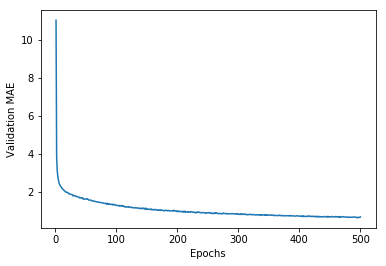

In [53]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) +1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

### 绘制验证分数(删除前10个数据点)

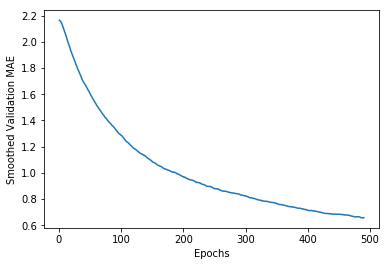

In [56]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smoothed_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smoothed_mae_history) + 1), smoothed_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Smoothed Validation MAE")
plt.show()

## 训练最终模型

In [ ]:
model = build_model()
model.fit(train_data, train_labels, epochs = 80, batch_size = 16, verbose = 0)

test_mse_score, test_mae_score = model.evaluate(test_test, test_labels)